½# SF task: Known unknowns

In this exercise we would like you to:

- build SOTA solution for image classification,
- find a way to find out if your model works really bad


### SOTA CNN Solution for image classification.

In this task you need to build a CNN model which:

- will be trained on a [`cifar 10`](https://www.cs.toronto.edu/~kriz/cifar.html), 
- will have a stem like in `ResNet 50`, 
- will have at least one skip connection,

A properly solved task should consist of:
- a code cell with a `stem` definition with appropriate citation and image added,
- a code cell with a skip-connection definition with appropriate image added,
- training a model on `CIFAR 10` which achieves at least 70% of accuracy on a test set from `CIFAR 10`.


### Diving into knowing about what do we don't know

The second task is to assess the certainty of your classifier. Your task is to propose a certainty metric which based on your model - will make prediction if a given prediction can be trusted or not.

A properly solved task should consist of:
- a code cell with definition of your metric and a text cell with its explaination,
- a code cell with a histogram of this metric for both properly classified and misclassified examples from CIFAR 10 dataset (histogram should compare distribution of your metric on properly and wrongly classified data).


### Code wrap up: 

Please wrap up your model in the following class as it will be tested against additional dataset:


In [2]:
import os
import pandas as pd
from keras.constraints import maxnorm
from keras.utils import np_utils
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras


print(tf.config.list_physical_devices('GPU'))

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


class Model:

    def __init__(self, num_classes=10, activation = 'relu', padding = 'same', dropout = 0.2, 
                 momentum = 0.9, nesterov = False, shape=(32, 32, 3), pool_size = (2, 2), lrate = 0.01, kernel_size = (3, 3)):
        super(Model, self).__init__()

        self.num_classes = num_classes
        self.inputs = keras.Input(shape=shape)
        self.kernel_size = kernel_size
        self.activation = activation
        self.padding = padding
        self.dropout = dropout
        self.momentum = momentum
        self.nesterov = nesterov
        self.pool_size = pool_size
        self.lrate = lrate
        self.decay = self.lrate / 100

    # stem structure image below
    def make_stem(self, filters=[32, 32, 64], shape=(32, 32, 3)):
        filter1, filter2, filter3 = filters
        stem = keras.layers.Conv2D(filter1, self.kernel_size, input_shape=shape, activation=self.activation,
                                   padding=self.padding)(self.inputs)
        stem = keras.layers.Conv2D(filter2, self.kernel_size, input_shape=shape, activation=self.activation,
                                   padding=self.padding)(stem)
        stem = keras.layers.Conv2D(filter3, self.kernel_size, input_shape=shape, activation=self.activation,
                                   padding=self.padding)(stem)
        stem = keras.layers.MaxPooling2D(self.kernel_size, strides=(2, 2), padding=self.padding)(stem)
        return stem

    def make_skip_connection(self, input, filter=64):
        skip = keras.layers.Conv2D(filter, self.kernel_size, activation=self.activation, padding=self.padding)(input)
        layer = keras.layers.Dropout(self.dropout)(skip)
        layer = keras.layers.Conv2D(filter, self.kernel_size, padding=self.padding)(layer)
        merge = keras.layers.add([layer, skip])
        activation = keras.layers.Activation('relu')(merge)
        return activation

    def make_main_block(self, input, filter):
        block = keras.layers.Conv2D(filter, self.kernel_size, activation=self.activation, padding=self.padding)(input)
        block = keras.layers.Dropout(self.dropout)(block)
        block = keras.layers.Conv2D(filter, self.kernel_size, activation=self.activation, padding=self.padding)(block)
        block = keras.layers.MaxPooling2D(pool_size=self.pool_size)(block)
        return block

    def make_dense_dropout(self, input, filter, kernel_constraint=maxnorm(3)):
        dense = keras.layers.Dense(filter, activation=self.activation, kernel_constraint=kernel_constraint)(input)
        dropout = keras.layers.Dropout(self.dropout)(dense)
        return dropout

    def make_model(self):
        output = self.make_stem()

        output = self.make_skip_connection(output)

        output = keras.layers.MaxPooling2D(pool_size=self.pool_size)(output)

        output = self.make_main_block(output, 128)
        output = self.make_main_block(output, 256)

        output = keras.layers.Flatten()(output)
        output = keras.layers.Dropout(self.dropout)(output)

        output = self.make_dense_dropout(output, 1024)
        output = self.make_dense_dropout(output, 512)

        output = keras.layers.Dense(self.num_classes, activation='softmax')(output)

        return keras.Model(inputs=self.inputs, outputs=output)

    def compile_model(self, model):
        optimizer = tf.keras.optimizers.SGD(learning_rate=self.lrate,
                                            momentum=self.momentum,
                                            decay=self.decay,
                                            nesterov=self.nesterov)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

    def build_model(self):
        model = self.make_model()
        print(model.summary())
        self.compile_model(model)
        return model


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ResNet50 18-layer architecture that I've used from the: Wang, Shuai & Xia, Xiaojun & Ye, Lanqing & Yang, Binbin. (2021). Automatic Detection and Classification of Steel Surface Defect Using Deep Convolutional Neural Networks. Metals. 11. 388. 10.3390/met11030388. 

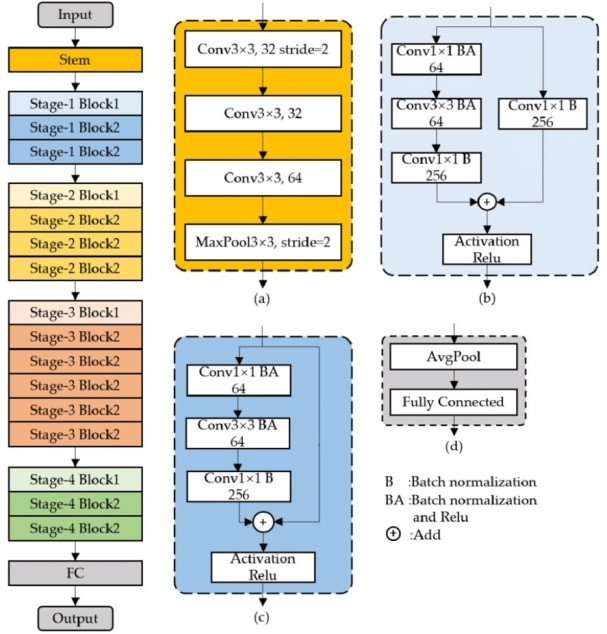

Stem structure

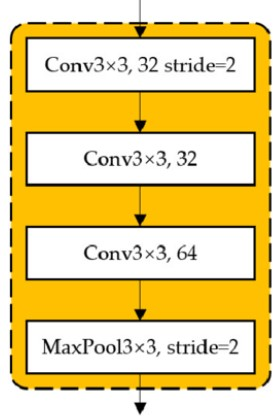

Building the model:

In [3]:
model = Model().build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d_1[0][0]']               
                                                                                              

Loading data

In [4]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

data = cifar10.load_data()

Training model:

In [5]:
def train(model, data, epochs = 10, batch_size = 32):
    
    # load data
    (x_train, y_train), (x_test, y_test) = data
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=1)
    
    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')

    # normalizing inputs from 0-255 to 0.0-1.0
    x_train = x_train / 255.0
    x_val = x_val / 255.0

    y_train = np_utils.to_categorical(y_train)
    y_val = np_utils.to_categorical(y_val)
    num_classes = y_test.shape[1]

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size)
    model.save("new_model.h5")

Charts methods

In [6]:
def plot_barchart(df_corect, df_wrong):
    df = pd.concat([df_corect, df_wrong])
    df = pd.DataFrame(df.mean(axis=0), columns=['Certainty'])
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': 'predictions'})
    df.sort_values('predictions').plot.bar(x="predictions", y="Certainty", rot=70, figsize=(10, 5))
    plt.show(block=True)


def plot_histogram(df):
    histogram = df[sorted(df.columns)]
    axarr = histogram.hist(sharex=True, sharey=True, figsize=(20, 10))

    for ax in axarr.flatten():
        ax.set_xlabel("Certainty")
        ax.set_ylabel("Count")
    plt.show(block=True)


class Charts:

    def __init__(self, certainties, predictions, labels) -> None:
        super(Charts, self).__init__()
        self.certainties = certainties
        self.predictions = predictions
        self.labels = labels

        self.df_pred_correct = pd.DataFrame()
        self.df_pred_wrong = pd.DataFrame()
        self.df_pred_correct_after = pd.DataFrame()
        self.df_pred_wrong_after = pd.DataFrame()

        self.build_dataframes()

    def build_dataframes(self):
        for i in range(0, self.certainties.size):
            if self.predictions[i] == self.labels[i]:
                temp_df = pd.DataFrame([[self.certainties[i]]], columns=["c " + str(self.labels[i])])
                self.df_pred_correct = pd.concat([self.df_pred_correct, temp_df])
                temp_df = pd.DataFrame([[self.certainties[i]]], columns=[str(self.labels[i]) + " c"])
                self.df_pred_correct_after = pd.concat([self.df_pred_correct_after, temp_df])
            else:
                temp_df = pd.DataFrame([[self.certainties[i]]], columns=["w " + str(self.predictions[i])])
                self.df_pred_wrong = pd.concat([self.df_pred_wrong, temp_df])
                temp_df = pd.DataFrame([[self.certainties[i]]], columns=[str(self.labels[i]) + " w"])
                self.df_pred_wrong_after = pd.concat([self.df_pred_wrong_after, temp_df])

    def plot_barcharts(self):
        print('\nAverage certainty per class - correct on the left and wrong on the right')
        plot_barchart(self.df_pred_correct, self.df_pred_wrong)
        print('\nAverage certainty for comparing differences between each class correct and wrong')
        plot_barchart(self.df_pred_correct_after, self.df_pred_wrong_after)

    def plot_histograms(self):
        print('\nHistogram correct prediction certainty per class')
        plot_histogram(self.df_pred_correct)
        print('\nHistogram wrong prediction certainty per class')
        plot_histogram(self.df_pred_wrong)

Extra methods

In [7]:
def accuracy(preds, labels):
    dict_acc_ev = {}
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

    correct = 0
    total = 0
    result = 0
    total += np.size(labels)
    correct += (preds == labels).sum().item()
    result = 100 * correct / total

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # collect the correct predictions for each class
    for label, prediction in zip(labels, preds):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

    # collect accuracy for each class
    for classname, correct_count in correct_pred.items():
        if total_pred[classname] != 0:
            class_acc = 100 * float(correct_count) / total_pred[classname]
            dict_acc_ev[classname] = class_acc

    df_class_accuracy = pd.DataFrame.from_dict(dict_acc_ev, orient='index')
    df_class_accuracy = df_class_accuracy.T
    return result, df_class_accuracy    

def predict(model, input_array: np.ndarray) -> np.ndarray:
    predictions = []
    for row in input_array:
        input = np.array(row).reshape((1, 32, 32, 3)).astype('float32') / 255
        predictions.append(np.argmax(model.predict(input).ravel()))
    return np.array(predictions)

# Given a batch of examples return a batch of certainty levels.
# predict gives vector of probabilities and display the max probability
def certainty(model, input_array: np.ndarray) -> np.ndarray:
    certainties = []
    for row in input_array:
        input = np.array(row).reshape((1, 32, 32, 3)).astype('float32') / 255
        prediction = model.predict(input).ravel()
        certainties.append(np.max(prediction))
    return np.array(certainties)

def plot_charts(certainties, predictions, labels):
    charts = Charts(certainties, predictions, labels)
    charts.plot_barcharts()
    charts.plot_histograms()

Evaluate model

In [8]:
def evaluate(model, input_array: np.ndarray, labels):
    
    predictions = []
    certainties = []
    for row in input_array:
        input = np.array(row).reshape((1, 32, 32, 3)).astype('float32') / 255
        prediction = model.predict(input).ravel()
        certainties.append(np.max(prediction))
        predictions.append(np.argmax(prediction))

    predictions = np.array(predictions)
    certainties = np.array(certainties)
    accuracy_o = accuracy(predictions, labels)

    # print(y_test)
    # print(predictions)
    # print(certainties)
    print(accuracy_o)

    return predictions, certainties, accuracy_o

In [9]:
# to load saved model run this

# from google.colab import drive
# drive.mount('/content/gdrive')
# root_dir = "/content/"

# model_img = keras.models.load_model(root_dir+'new_model.h5')
# predictions, certainties, accuracy = evaluate(model_img, data)

# plot_charts(predictions, certainties, accuracy)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 32)   896         ['input_3[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_18[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 64)   18496       ['conv2d_19[0][0]']              
                                                                                            

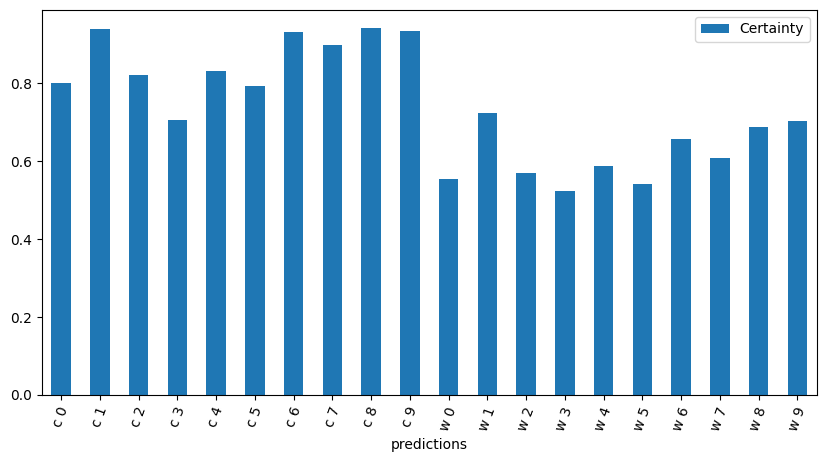


Average certainty for comparing differences between each class correct and wrong


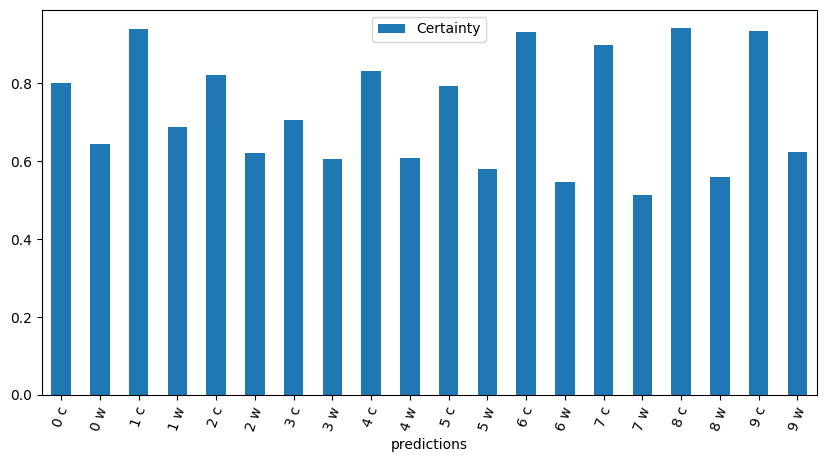


Histogram correct prediction certainty per class


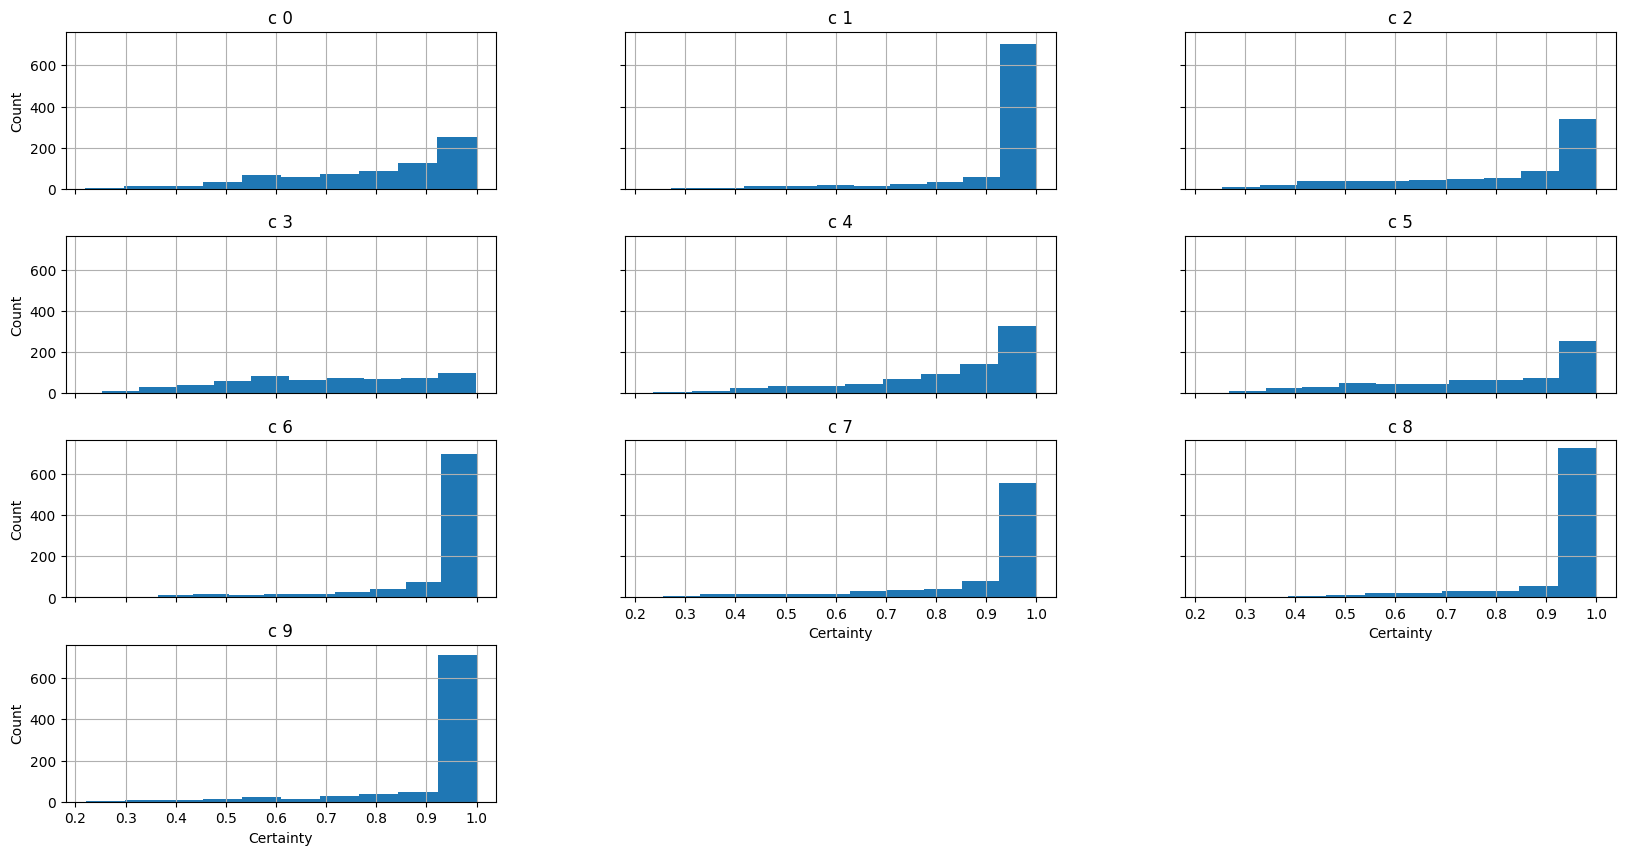


Histogram wrong prediction certainty per class


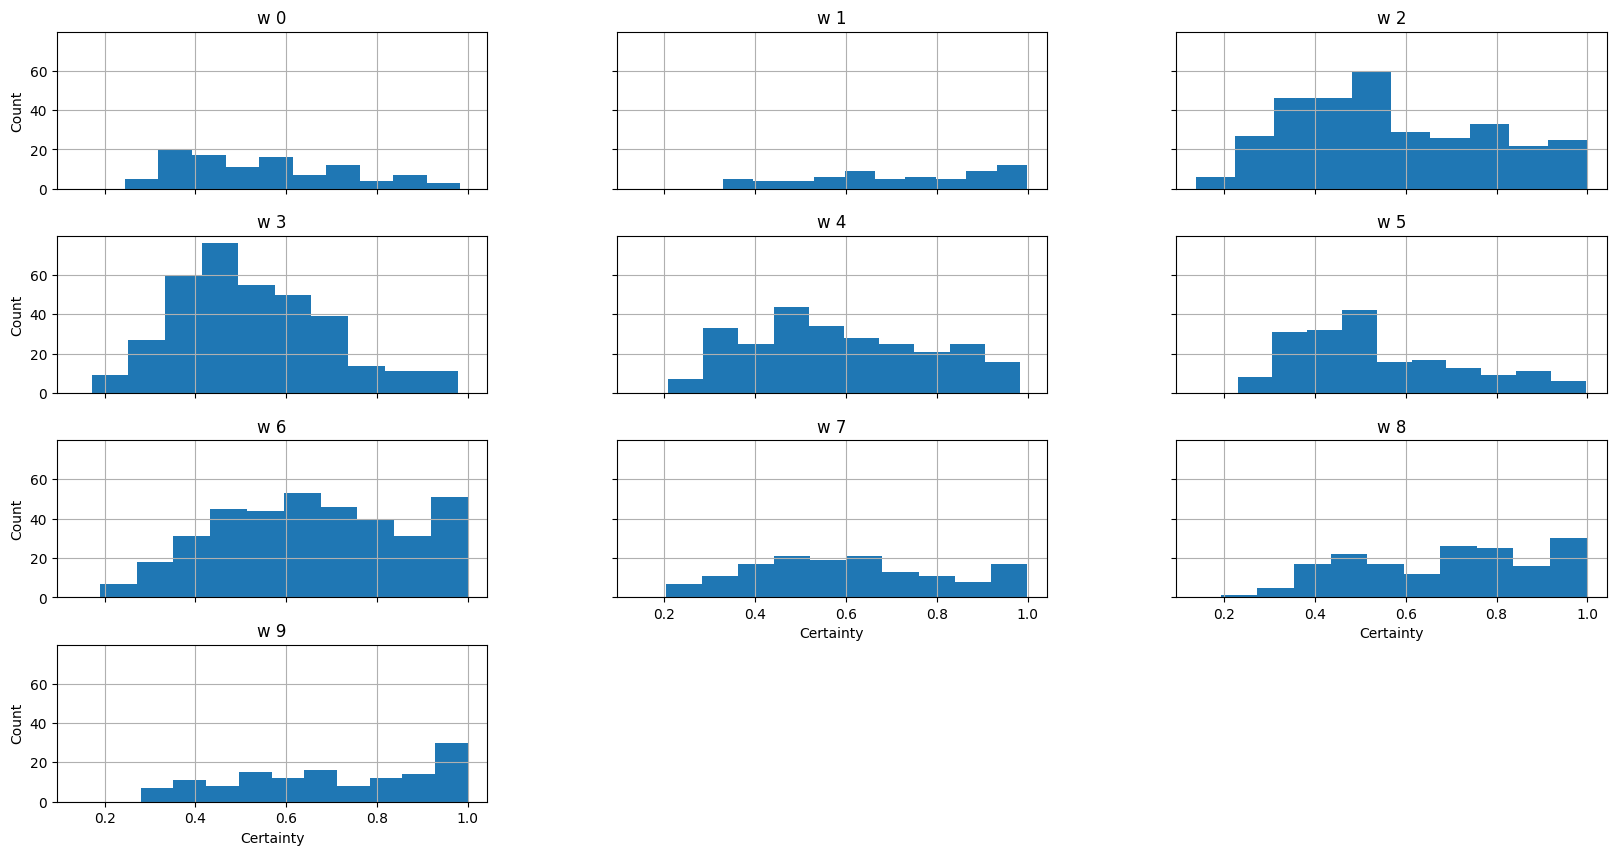

In [11]:
model = Model().build_model()

train(model, data, epochs = 10, batch_size = 32)

(x_train, y_train), (x_test, y_test) = data
    
y_test = y_test.flatten()

predictions, certainties, accuracy_o = evaluate(model, x_test, y_test)

#If the histogram is not readable run this
plot_charts(certainties, predictions, y_test)

Accuracy per class:

0     1     2     3     4     5     6     7     8     9

80.9  90.5  61.1  57.1  75.1  67.7  92.5  81.5  90.6  85.5


Overall accuracy at 10 epochs: 78.25% 

